[*********************100%***********************]  11 of 11 completed


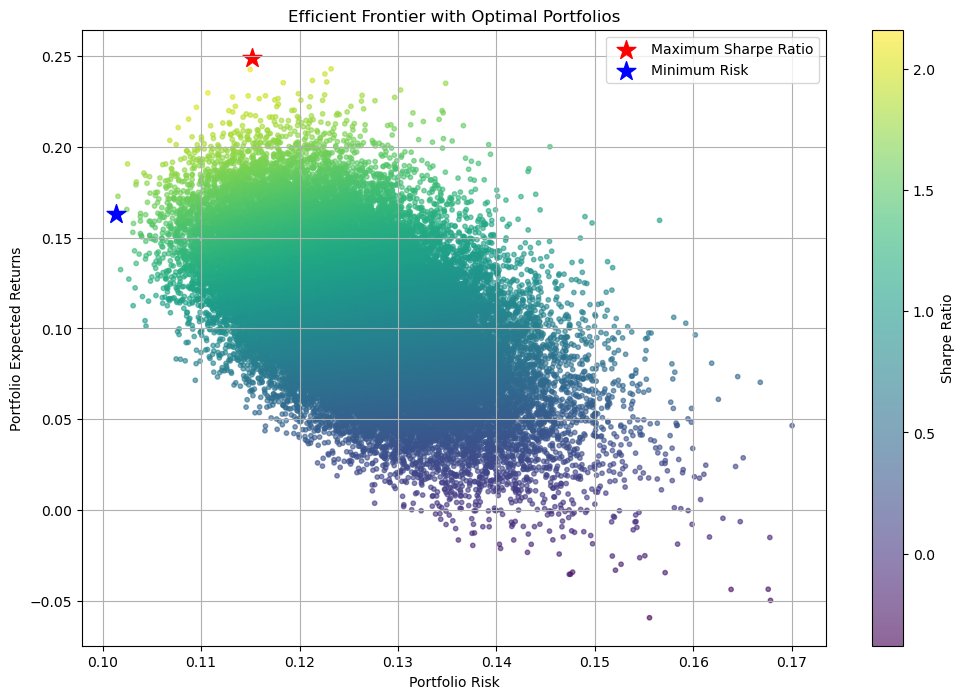

In [60]:
import numpy as np
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 데이터 불러오기
data = pd.read_csv(f'/Users/leesangwon/Downloads/sector(assets)_개별종목_호준.csv', encoding="utf-8")
tickers = data['티커'].tolist()

# 티커를 섹터(자산군)으로 매핑
ticker_to_name = dict(zip(data['티커'], data['섹터(자산군)']))

# 데이터 다운로드
data = yf.download(tickers, start="2014-01-01", end="2014-12-31")['Adj Close']

# 칼럼명을 섹터(자산군)으로 변환
data.rename(columns=ticker_to_name, inplace=True)

# 로그 수익률 계산
log_returns = data.pct_change().apply(lambda x: np.log(1 + x)).dropna()

# 연간 기대수익률과 공분산 계산
ret_annual = log_returns.mean() * 250  # 250 영업일 기준
cov_annual = log_returns.cov() * 250   # 연간 공분산

# 포트폴리오 수익률, 변동성, 가중치를 저장할 리스트
p_returns = []
p_Risk = []
p_weights = []
sharpe_ratios = []  # 샤프 비율 저장

# 투자 자산 수와 포트폴리오 시뮬레이션 개수 설정
n_assets = len(tickers)
n_ports = 50000

# 포트폴리오 시뮬레이션
for _ in range(n_ports):
    weights = np.random.random(n_assets)
    weights /= np.sum(weights)  # 비중 합계 1로 정규화
    
    # 기대수익률과 변동성 계산
    portfolio_return = np.dot(weights, ret_annual)
    portfolio_Risk = np.sqrt(np.dot(weights.T, np.dot(cov_annual, weights)))
    sharpe_ratio = portfolio_return / portfolio_Risk  # 샤프 비율 계산
    
    # 결과 저장
    p_returns.append(portfolio_return)
    p_Risk.append(portfolio_Risk)
    p_weights.append(weights)
    sharpe_ratios.append(sharpe_ratio)

# NumPy 배열로 변환
p_returns = np.array(p_returns)
p_Risk = np.array(p_Risk)
sharpe_ratios = np.array(sharpe_ratios)

# 최적 포트폴리오 계산 (Sharpe Ratio 최대화)
max_sharpe_idx = sharpe_ratios.argmax()  # 최대 Sharpe Ratio 인덱스
max_sharpe_return = p_returns[max_sharpe_idx]
max_sharpe_Risk = p_Risk[max_sharpe_idx]
max_sharpe_weights = p_weights[max_sharpe_idx]

# 최소 변동성 포트폴리오 계산
min_Risk_idx = p_Risk.argmin()  # 최소 변동성 인덱스
min_Risk_return = p_returns[min_Risk_idx]
min_Risk_Risk = p_Risk[min_Risk_idx]
min_Risk_weights = p_weights[min_Risk_idx]

# 효율적 프론티어 시각화
plt.figure(figsize=(12, 8))
plt.scatter(p_Risk, p_returns, c=sharpe_ratios, cmap='viridis', marker='o', s=10, alpha=0.6)
plt.colorbar(label='Sharpe Ratio')
plt.scatter(max_sharpe_Risk, max_sharpe_return, c='red', marker='*', s=200, label='Maximum Sharpe Ratio')
plt.scatter(min_Risk_Risk, min_Risk_return, c='blue', marker='*', s=200, label='Minimum Risk')
plt.xlabel("Portfolio Risk")
plt.ylabel("Portfolio Expected Returns")
plt.title("Efficient Frontier with Optimal Portfolios")
plt.legend(loc="best")
plt.grid(True)
plt.show()

In [61]:
# 최적 포트폴리오 정보 출력
print("Maximum Sharpe Ratio Portfolio:")
print(f"Return: {max_sharpe_return:.2f}, Risk: {max_sharpe_Risk:.2f}")
print(f"Weights: {max_sharpe_weights}")

print("\nMinimum Risk Portfolio:")
print(f"Return: {min_Risk_return:.2f}, Risk: {min_Risk_Risk:.2f}")
print(f"Weights: {min_Risk_weights}")

# 종목별 비중을 데이터프레임으로 변환
def create_weights_dataframe(weights, tickers, portfolio_name):
    df = pd.DataFrame({
        'Ticker': tickers,
        'Weight': weights
    })
    df['Portfolio'] = portfolio_name
    return df

# 최대 Sharpe Ratio 포트폴리오 데이터프레임 생성
df_max_sharpe = create_weights_dataframe(max_sharpe_weights, tickers, 'Max Sharpe Ratio')

# 최소 변동성 포트폴리오 데이터프레임 생성
df_min_Risk = create_weights_dataframe(min_Risk_weights, tickers, 'Min Risk')

# 두 포트폴리오를 칼럼 방향으로 병합
weights_df = pd.concat([df_max_sharpe.set_index('Ticker')['Weight'], 
                        df_min_Risk.set_index('Ticker')['Weight']], 
                       axis=1)

# 칼럼 이름 설정
weights_df.columns = ['Max Sharpe Ratio', 'Min Risk']

# 결과 출력
weights_df = weights_df.round(4)
weights_df

Maximum Sharpe Ratio Portfolio:
Return: 0.25, Risk: 0.12
Weights: [0.00059705 0.15303267 0.0153715  0.22653668 0.03759515 0.24041395
 0.04116765 0.17915442 0.06718375 0.00071841 0.03822877]

Minimum Risk Portfolio:
Return: 0.16, Risk: 0.10
Weights: [0.01225216 0.25110125 0.19089323 0.04560426 0.09585531 0.07071196
 0.04840399 0.17380433 0.01622746 0.09147471 0.00367135]


,Max Sharpe Ratio,Min Risk
Ticker,,
NVDA,0.0006,0.0123
SPGI,0.1530,0.2511
LLY,0.0154,0.1909
AMZN,0.2265,0.0456
DE,0.0376,0.0959
TMUS,0.2404,0.0707
COST,0.0412,0.0484
MPC,0.1792,0.1738
EQIX,0.0672,0.0162
